# Radar Water Observations

First step is just configuration to access radar and wofs data.

In [1]:
%%bash
cat > radar.datacube << EOF
[default]
db_hostname: agdcdev-db.nci.org.au
db_port: 6432
db_database: radar
EOF

In [2]:
import datacube
import pytz
import functools
import digitalearthau.utils
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.filters
import matplotlib.patheffects
import sklearn.svm

def localdate(ds, tz=pytz.timezone('Australia/Sydney')):
    """Extract date string, for local timezone, from dataset record"""
    return str(ds.time.begin.replace(tzinfo=pytz.timezone('UTC')).astimezone(tz))[:10]

%matplotlib inline

We will build up a container for managing an observation.

In [3]:
class comparison:
    dc = {'wofs': datacube.Datacube(),
          'sar': datacube.Datacube(config='radar.datacube')}
    @classmethod
    def list_all(cls):
        """Returns list of all potential comparison instances"""
        return [cls(i) for i in cls.dc['sar'].find_datasets(product='s1_gamma0_scene')]
    def __init__(self, dataset_record):
        self.ds = dataset_record
        self.date = localdate(dataset_record)
    def __repr__(self):
        return '<' + self.date + '>'    
    
    @functools.lru_cache(maxsize=None)
    def wofs_datasets(self):
        """Search index for WOFS observations that potentially overlap the SAR observations"""
        return self.dc['wofs'].find_datasets(product="wofs_albers", geopolygon=self.ds.extent, time=self.date)

In [4]:
%%time
x = comparison.list_all()
print(len(x))
x[:5]

2433
CPU times: user 529 ms, sys: 43 ms, total: 572 ms
Wall time: 774 ms


Note that no grouping/fusing of radar images is occuring. TODO: This should be changed to ensure no pixels are double-counted, and will then need to switch to a grid workflow (rather than trying to fit an entire contiguous satellite pass into memory). As an initial prototype, it is simpler to just use the relatively few radar scenes as the unit of processing.

For now, just want to check for potential overlapping wofs scenes.

In [5]:
# @functools.lru_cache(maxsize=None)
# def wofs_datasets(self):
#     """Search index for WOFS observations that potentially overlap the SAR observations"""
#     return self.dc['wofs'].find_datasets(product="wofs_albers", geopolygon=self.ds.extent, time=self.date)
# comparison.wofs_datasets = wofs_datasets

In [6]:
%%time
x2 = [i for i in x if i.wofs_datasets()]
len(x2)

CPU times: user 2min, sys: 4.11 s, total: 2min 4s
Wall time: 6min 36s


It looks as though only a third of radar observations can potentially be paired with landsat observations, under the same-day constraint. Note there are more sophisticated constraints that could be considered instead, such as longer time-windows or even temporal brackets. However, same-day is fast to prototype with.

Next need to actually load the data, to determine whether datasets have overlapping valid pixels.

In [7]:
def load(self):
    """Retrieve full raster data"""
    radar = self.dc['sar'].load(product='s1_gamma0_scene', datasets=[self.ds], 
                                output_crs='epsg:3577', resolution=(25,-25))
    assert len(radar.time) == 1
    wofs = self.dc['wofs'].load(product='wofs_albers', datasets=self.wofs_datasets(), like=radar,
                                group_by='solar_day', fuse_func=digitalearthau.utils.wofs_fuser)
    assert len(wofs.time) == 1    
    
    return radar.isel(time=0), wofs.isel(time=0)
comparison.load = load

def overlay(self):
    """Extract and categorise comparable pixels"""
    radar, wofs = self.load()

    wet = wofs.water == 128
    dry = wofs.water == 0
    clear = wet | dry

    validradar = (radar.vv > 0) & (radar.vh > 0)

    overlap = clear & validradar
    self.overlap = overlap.data.sum()

    if self.overlap:
        def extract(subset):
            vv = radar.vv.values.ravel()[subset.values.ravel()]
            vh = radar.vh.values.ravel()[subset.values.ravel()]
            return vv, vh
        self.wet_vv, self.wet_vh = extract(wet & overlap)
        self.dry_vv, self.dry_vh = extract(dry & overlap)
    return self.overlap
comparison.overlay = overlay

In [8]:
%%time 
x2[0].overlay()

CPU times: user 14.9 s, sys: 4.89 s, total: 19.7 s
Wall time: 23.4 s


6379563

In [9]:
%%time
x3 = [i for i in x2[:10] if i.overlay()]

CPU times: user 1min 26s, sys: 33.8 s, total: 1min 59s
Wall time: 2min 17s


In [10]:
len(x3)

5

At this point all of the relevant data is available. It is useful now to aggregate before analysis.

Note, it would also have been an option to coarsely bin the measurement data at an earlier stage, to limit memory consumption.

A key point is that the relationship between polarisation bands is preserved. (This would require two-dimensional binning.)

In [11]:
wet_vv = np.concatenate([i.wet_vv for i in x3])
wet_vh = np.concatenate([i.wet_vh for i in x3])
dry_vv = np.concatenate([i.dry_vv for i in x3])
dry_vh = np.concatenate([i.dry_vh for i in x3])

Analysis will begin with visualising how the radar signal distributions depend on the wofs category.

In [12]:
sum([i.overlap for i in x3])

73740684

In [13]:
def prettyhist(vv, vh, extent=1.0, nbins=500, smoothing=0, downsampling=5, window=None, contours = [50,90,99]):
    nsamples = len(vv)
    d = downsampling # downsample factor for contour smoothing
    assert nbins//d == nbins/d # must be integer multiple
    
    counts, *edges = np.histogram2d(vh, vv, bins=nbins, range=[[0,extent]]*2) # binning
    
    nsamples -= counts[0,0] # exclude nodata
    counts[0,0] = 0
    
    downsample = counts.reshape(nbins//d,d,nbins//d,d).sum(axis=(3,1)) # aggregate to coarser bins
    flat = downsample.ravel()
    ind = np.argsort(flat)[::-1]
    cumulative = (np.cumsum(flat[ind]) * 100 / nsamples)[ind.argsort()].reshape(downsample.shape)
    smooth = scipy.ndimage.filters.gaussian_filter(cumulative, smoothing)
    
    counts[counts==0] = np.nan # mask zero counts
    plt.imshow(np.log10(counts), origin='lower', extent=[0,extent]*2)
    
    #plt.imshow(cumulative)
    c = plt.contour(smooth, levels=contours, colors='k', origin='lower', extent=[0,extent]*2)
    
    if window:
        plt.xlim(0, window)
        plt.ylim(0, window)
    
    cc = plt.clabel(c, fmt='%d%%', fontsize=12)
    plt.setp(cc, path_effects=[matplotlib.patheffects.withStroke(linewidth=3, foreground='w')])
        
    plt.xlabel('vv')
    plt.ylabel('vh')
    print(np.nansum(counts) / nsamples, cumulative.max())
#prettyhist(dry_vv, dry_vh, extent=0.6)

0.9992215393491597 99.92215393491597


Text(0.5, 1.0, 'Dry observations')

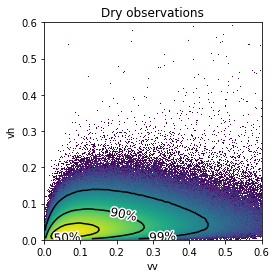

In [14]:
prettyhist(dry_vv, dry_vh, extent=0.6)
plt.title('Dry observations')

0.9992215393491597 99.92215393491597


Text(0.5, 1.0, 'Dry observations')

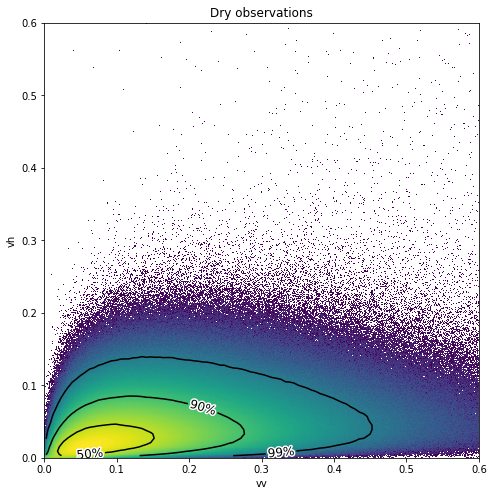

In [25]:
plt.figure(figsize=(8,8))
prettyhist(dry_vv, dry_vh, extent=0.6)
plt.title('Dry observations')

0.9975228766024659 99.75228766024658


Text(0.5, 1.0, 'Water observations')

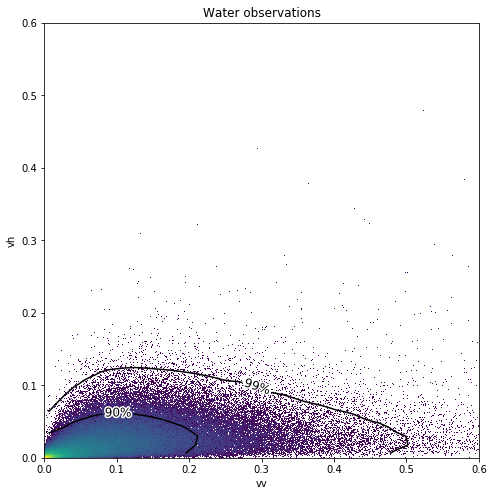

In [26]:
plt.figure(figsize=(8,8))
prettyhist(wet_vv, wet_vh, extent=0.6, downsampling=10, smoothing=1, contours=[50,90,99])
plt.title('Water observations')

0.9975228766024659 99.75228766024658


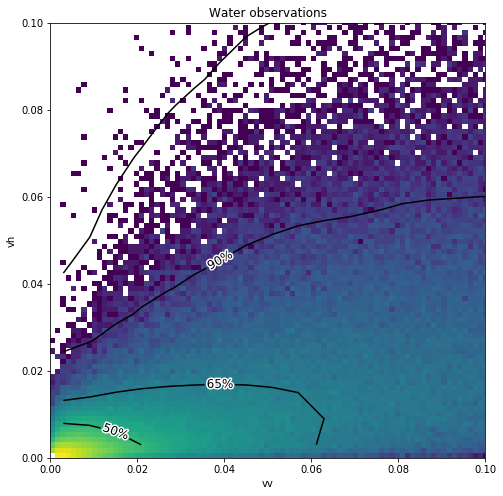

In [27]:
plt.figure(figsize=(8,8))
prettyhist(wet_vv, wet_vh, extent=0.6, window=0.1, smoothing=1, downsampling=5, contours=[50,65,90,99])
plt.title('Water observations')
None

0.9992215393491597 99.92215393491597


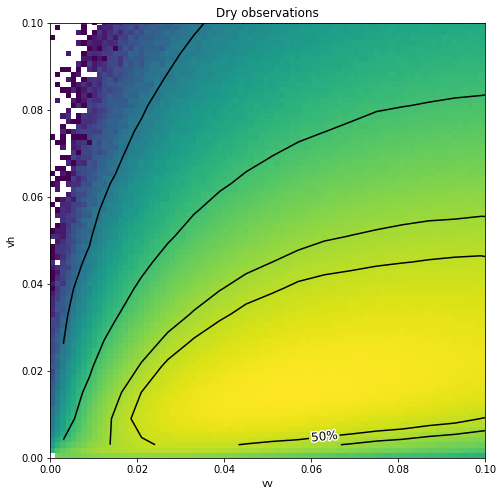

In [28]:
plt.figure(figsize=(8,8))
prettyhist(dry_vv, dry_vh, extent=0.6, window=0.1, contours=[50,65,90,99])
plt.title('Dry observations')
None

The obvious further step is to apply Bayes theorem (and knowledge of the overall frequency of water in the dataset) to map predictions across this polarisations space.

In [29]:
wets = len(wet_vv)
drys = len(dry_vv)
obs = wets + drys

pw = wets/obs # prior (i.e. overall for any pixel) probabilities of wet or dry
pd = drys/obs

def hist(vv,vh, nbins=1000, extent=0.6):
    counts, *edges = np.histogram2d(vh, vv, bins=nbins, range=[[0,extent]]*2) # binning
    return counts

ow = hist(wet_vv, wet_vh) / wets # likelihood of data given the class
od = hist(dry_vv, dry_vh) / drys

po = ow*pw + od*pd # probability of observation, the Bayes normalising factor

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Text(0, 0.5, 'vh')

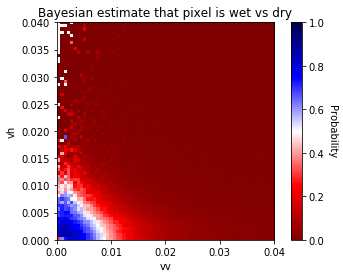

In [30]:
probwet = (ow*pw) / po
plt.imshow(probwet, origin='lower', extent=[0,0.6]*2, cmap='seismic_r')
s=0.04
plt.xlim(0,s)
plt.ylim(0,s)
cb = plt.colorbar()
cb.ax.get_yaxis().labelpad = 12
cb.ax.set_ylabel('Probability', rotation=270)
plt.title('Bayesian estimate that pixel is wet vs dry')
plt.xlabel('vv')
plt.ylabel('vh')

Quick stats: How accurate is this prediction going to be?

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


(0, 0.04)

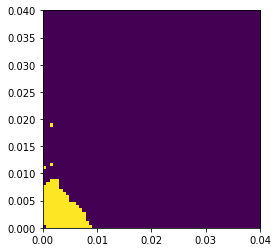

In [31]:
plt.imshow(probwet>0.5, origin='lower', extent=[0,0.6]*2)
s=0.04
plt.xlim(0,s)
plt.ylim(0,s)

In [32]:
np.where(np.nan_to_num(probwet)>0.5, ow, 0).sum()

0.3072239958423052

In [33]:
np.where(np.nan_to_num(probwet)<=0.5, od, 0).sum()

0.9985489574949353

In [34]:
np.where(np.nan_to_num(probwet)>0.5, od, 0).sum() * drys/wets

0.1181302824406822

A simplified approach is to pick a straight line to divide the polarisation space into two predictions. This is a support vector machine classifier with linear kernel. In some sense this is the simplest way of utilising both polarisation bands in a per-pixel decision, and hence it is *a priori* a natural approach. It is also the method adopted by WASARD. 

The approximately linear shape of the 0.5 contour in the Bayesian plot above validates this approach.

In [44]:
uniq = np.unique(probwet)
uniq = uniq[np.isfinite(uniq)] 
uniq.sort()
len(uniq)

14936

In [106]:
points = np.linspace(0,1,1000)

In [111]:
masker = np.nan_to_num(probwet)
true_pos = np.asarray([np.where(masker > i, ow, 0).sum() for i in points]) * wets

In [141]:
masker.min(), masker.max()

(0.0, 1.0)

In [112]:
false_neg = np.asarray([np.where(masker <= i, ow, 0).sum() for i in points]) * wets
false_pos = np.asarray([np.where(masker > i, od, 0).sum() for i in points]) * drys
true_neg = np.asarray([np.where(masker <= i, od, 0).sum() for i in points]) * drys

In [116]:
sensitivity = true_pos / (true_pos + false_neg)
specificity = true_neg / (true_neg + false_pos)
falsediscovery = false_pos / (true_pos + false_pos)

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


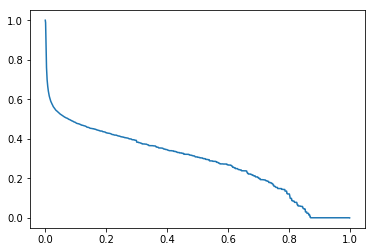

In [117]:
plt.plot(points, sensitivity)

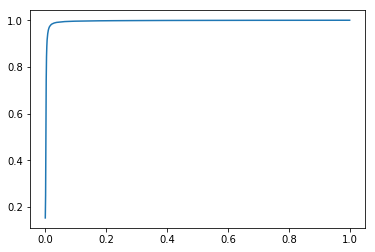

In [118]:
plt.plot(points, specificity)
#plt.xlim(0,5)

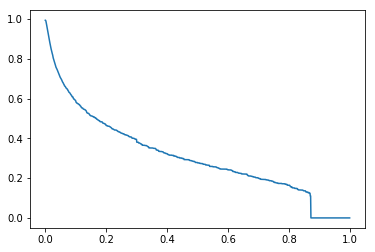

In [119]:
plt.plot(points, falsediscovery)

Text(0.5, 1.0, 'Receiver operating characteristic')

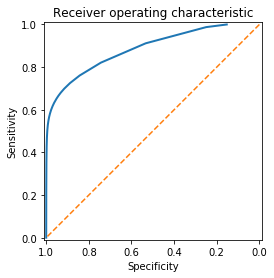

In [154]:
#plt.plot(1-specificity, np.vstack([sensitivity,1-specificity]).T)
plt.plot(specificity, sensitivity, linewidth=2)
plt.plot(points, 1-points, '--')
plt.gca().set_aspect('equal')
plt.xlim(1.01,-0.01)
plt.ylim(-0.01,1.01)
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver operating characteristic')

Text(0.5, 0, 'False discovery rate')

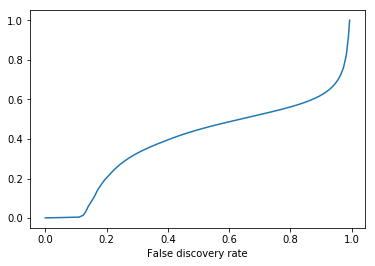

In [164]:
plt.plot(falsediscovery, sensitivity)
plt.xlabel('False discovery rate')

In [45]:

true_pos = [np.where()
false_neg = 
false_pos 
true_neg = 

array([0.00000000e+00, 2.16216216e-04, 2.25529995e-04, ...,
       8.69276851e-01, 8.71101871e-01, 1.00000000e+00])

The remaining questions are how good is this approach (i.e. does the output look good or do accuracy statistics meet acceptance thresholds), and is it worth trying to augment the decision with additional information (such as spatial context, temporal context, other sensors, and/or SAR methods beyond backscatter intensity)?